# Accelerated MRI reconstruction using DeepInverse

1. [Plug-and-play with a pretrained denoiser](#1-plug-and-play-with-a-pretrained-denoiser)
2. [Self-supervised unrolled learning](#2-self-supervised-feedforward-learning)
3. [Posterior sampling from a diffusion model](#3-posterior-sampling-from-a-diffusion-model)

By [Andrew Wang](https://andrewwango.github.io)

In [ ]:
!pip install deepinv

In [4]:
import deepinv as dinv
import torch

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
rng = torch.Generator(device=device).manual_seed(0)
img_size = (128, 128)

import matplotlib as mpl; mpl.rcParams.update({"text.usetex": True, "text.latex.preamble": r"\usepackage{amsmath}"})

#### Define physics and data

In [5]:
physics_generator = dinv.physics.generator.GaussianMaskGenerator(
    img_size=img_size, acceleration=4, rng=rng, device=device
)
physics = dinv.physics.MRI(img_size=img_size, device=device)

In [6]:
from torchvision.transforms import Resize
train_dataset = dinv.datasets.SimpleFastMRISliceDataset(".", file_name="fastmri_knee_singlecoil.pt", transform=Resize(128), train=True, train_percent=0.8, download=True)
test_dataset  = dinv.datasets.SimpleFastMRISliceDataset(".", file_name="fastmri_knee_singlecoil.pt", transform=Resize(128), train=False, train_percent=0.8,)

train_dataset = torch.utils.data.Subset(train_dataset, range(min(len(train_dataset), 10)))
test_dataset  = torch.utils.data.Subset(test_dataset,  range(min(len(test_dataset), 1)))

path = dinv.datasets.generate_dataset(
    train_dataset=train_dataset, 
    test_dataset=test_dataset, 
    physics=physics, 
    physics_generator=physics_generator, 
    save_physics_generator_params=True, 
    overwrite_existing=False, 
    device=device, 
    save_dir=".", 
    batch_size=1
)

train_dataset, test_dataset = dinv.datasets.HDF5Dataset(path, split="train", load_physics_generator_params=True), dinv.datasets.HDF5Dataset(path, split="test", load_physics_generator_params=True)
train_dataloader, test_dataloader = torch.utils.data.DataLoader(train_dataset), torch.utils.data.DataLoader(test_dataset)

C:\Users\s2558406\Documents\Repos\deepinv\deepinv\datasets\datagenerator.py:246: UserWarning: Dataset ./dinv_dataset0.h5 already exists, skipping...
  warn(f"Dataset {hf_path} already exists, skipping...")


#### Look at sample data

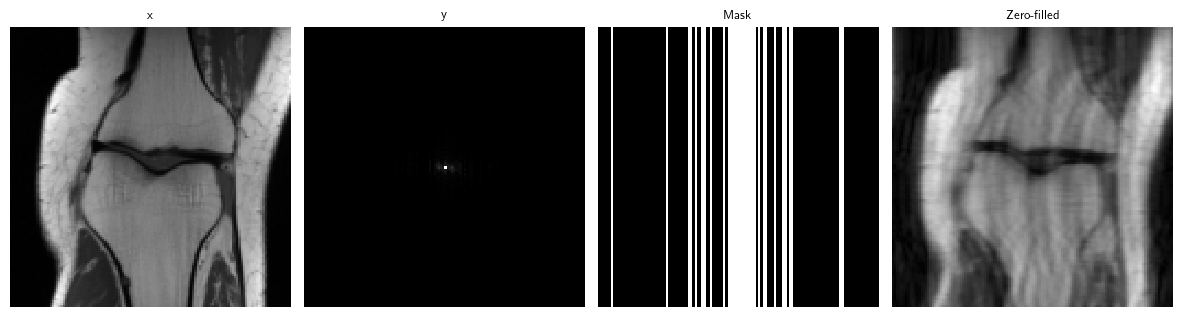

In [7]:
x, y, params = next(iter(test_dataloader))
dinv.utils.plot({
    "x": x,
    "y": y,
    "Mask": params["mask"],
    "Zero-filled": physics.A_adjoint(y, **params)
}, figsize=(15, 4))

## 1. Plug-and-play with a pretrained denoiser

Following DPIR [1], we replace the prior with a pretrained DRUNet denoiser.

`model = dinv.optim.DPIR(0.01, device=device).to(device)`

[1] Zhang et al., [_"Plug-and-Play Image Restoration with Deep Denoiser Prior"_](https://arxiv.org/abs/2008.13751)

#### Define PnP model

In [13]:
class DRUNetWrapper(dinv.models.DRUNet):
    def forward(self, x, sigma):
        return super().forward(torch.cat([x, torch.zeros_like(x)[:, :1]], dim=1), sigma)[:, :2]
    
sigma_denoiser, stepsize, max_iter = dinv.optim.dpir.get_DPIR_params(0.01)

model = dinv.optim.optim_builder(
    iteration = "HQS",
    prior = dinv.optim.PnP(denoiser=DRUNetWrapper(pretrained="download", device=device)),
    data_fidelity = dinv.optim.L2(),
    early_stop=False,
    max_iter=max_iter,
    verbose=True,
    params_algo={"stepsize": stepsize, "g_param": sigma_denoiser},
).to(device)

#### Perform inference

Test:   0%|                                                                                     | 0/1 [00:04<?, ?it/s, PSNR=28.6, PSNR no learning=23]

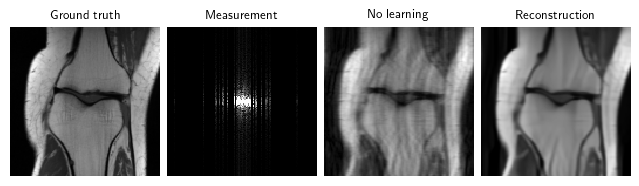

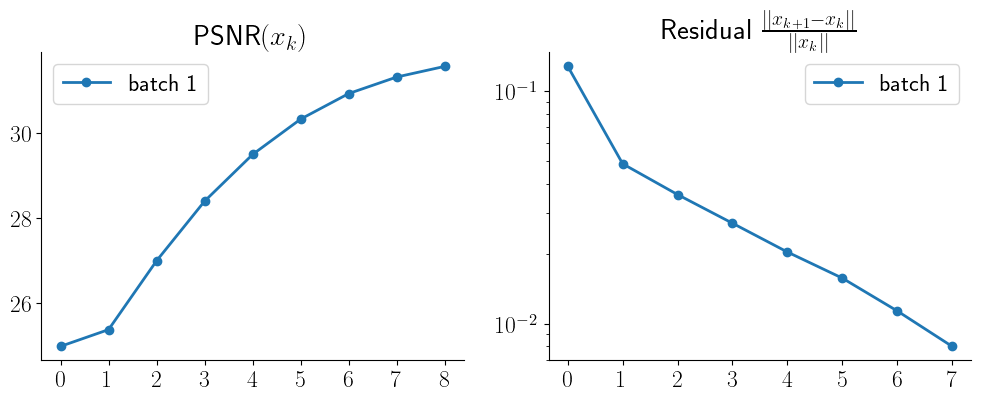

Test: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it, PSNR=28.6, PSNR no learning=23]

Test results:
PSNR no learning: 23.009 +- 0.005
PSNR: 28.558 +- 0.000


In [14]:
results = dinv.Trainer(
    model = model,
    physics = physics,
    optimizer = None,
    train_dataloader = None,
    metrics = dinv.metric.PSNR(complex_abs=True),
    device = device,
    plot_images = True,
    plot_convergence_metrics=True
).test(test_dataloader)

## 2. Self-supervised feedforward learning

The EI self-supervised loss assumes that the set of signals is invariant to a group of transformations in order to learn from incomplete measurement data alone:

$\mathcal{L}_\text{EI}=\lVert T_g \hat{x} - f(A(T_g \hat{x}), A)\rVert_2^2$

where $\hat{x}=f(y, A)$ is a reconstructed signal and $T_g$ is a transformation sampled at random from a group $g\sim G,\,G=\text{Diff}(\mathbb{R}^n)$.

[2] Chen D., Tachella J. & Davies M., [_"Equivariant Imaging: Learning Beyond the Range Space"_](https://arxiv.org/abs/2103.14756)  
[3] Wang A. & Davies M., [_"Fully unsupervised dynamic MRI reconstruction"_](https://arxiv.org/abs/2410.08646)

#### Define the model: unroll the PnP

We now unroll the optimisation and learn the PnP denoiser end-to-end [4]:

`model = dinv.models.MoDL(num_iter=3, denoiser=dinv.models.UNet(2, 2)).to(device)`

[4] Aggarwal et al., [_"MoDL: Model Based Deep Learning Architecture for Inverse Problems"_](https://arxiv.org/abs/1712.02862)

In [10]:
model = dinv.unfolded.unfolded_builder(
    "HQS",
    prior=dinv.optim.PnP(denoiser=dinv.models.UNet(2, 2, scales=3)),
    data_fidelity=dinv.optim.L2(),
    max_iter=3,
    trainable_params=["lambda", "stepsize", "g_param"],
    params_algo={
        "stepsize": [1., 1., 1.],
        "g_param": [.01, .01, .01],
        "lambda": [1., 1., 1.],
    },
).to(device)

#### Define self-supervised loss and train!

In [11]:
loss = [
    dinv.loss.MCLoss(),
    dinv.loss.EILoss(transform=dinv.transform.CPABDiffeomorphism(device=device))
]

In [12]:
trainer = dinv.Trainer(
    model = model,
    physics = physics,
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3),
    train_dataloader = train_dataloader,
    eval_dataloader = test_dataloader,
    epochs = 0,
    losses = loss,
    scheduler = None,
    metrics = dinv.metric.PSNR(complex_abs=True),
    ckp_interval = 10,
    device = device,
    eval_interval = 1,
    save_path = ".",
    plot_images = False,
    wandb_vis = False
)

_ = trainer.train()

The model has 2070091 trainable parameters


Test:   0%|                                                                                     | 0/1 [00:00<?, ?it/s, PSNR=27.6, PSNR no learning=23]

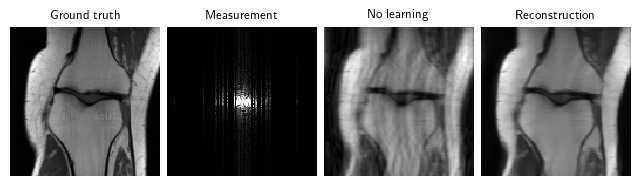

Test: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s, PSNR=27.6, PSNR no learning=23]

Test results:
PSNR no learning: 23.009 +- 0.005
PSNR: 27.554 +- 0.005


In [13]:
trainer.plot_images = True
trainer.load_model("diffeo-ei.pth.tar")
results = trainer.test(test_dataloader)

## 3. Posterior sampling from a diffusion model

We sample from a posterior distribution with a diffusion prior using the DPS data fidelity.

[5] Chung et al., [_"Diffusion Posterior Sampling for General Noisy Inverse Problems"_](https://arxiv.org/abs/2209.14687)

```model = dinv.sampling.DPS(denoiser, data_fidelity=dinv.optim.L2()).to(device)```

#### Define pretrained diffusion model

In [ ]:
class DiffUNetWrapper(dinv.models.DiffUNet):
    def forward(self, x, t, y=None, type_t="noise_level"):
        return super().forward(torch.cat([x, torch.zeros_like(x)[:, :1]], dim=1), t, y, type_t)[:, :2]
    
denoiser = DiffUNetWrapper(pretrained="download").to(device)

model = dinv.sampling.PosteriorDiffusion(
    data_fidelity = dinv.sampling.DPSDataFidelity(denoiser=denoiser),
    denoiser = denoiser,
    sde = dinv.sampling.VarianceExplodingDiffusion(
        sigma_max=20,
        sigma_min=0.02,
        alpha=0.5,
        device=device,
    ),
    solver = dinv.sampling.EulerSolver(timesteps=torch.linspace(1, 0.001, 10), rng=rng),
    device = device,
    verbose = True,
)

#### Perform posterior sampling

In [ ]:
x_hat, trajectory = model(y, physics, seed=0, get_trajectory=True)
torch.save(trajectory, "trajectory.pt")

100%|██████████| 9/9 [00:14<00:00,  1.58s/it]


In [ ]:
dinv.utils.plot_videos(torch.load("trajectory.pt"), time_dim=0, display=True)

<Figure size 640x480 with 0 Axes>